In [50]:
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from scipy import misc
import numpy as np
from skimage import color
from skimage.color import rgb2gray
from os import listdir
from os.path import isfile
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import cv2

# Import Data

#List folders in the root directory
root_path = '/Users/ckruse/Documents/Python/LegoModel/'
image_path = root_path+'Bricks/'
root_folders = listdir(image_path)

#Load image names into image_array by iterating through all the folders in the root directory
num_img = 0
for folder in root_folders:
    if isfile(folder) == False:
        folder_files = listdir("%s%s" % (image_path, folder))
        num_img += len(folder_files)

# input image dimensions
img_rows = cv2.imread("%s%s/%s" % (image_path, folder, folder_files[1])).shape[1]
img_cols = cv2.imread("%s%s/%s" % (image_path, folder, folder_files[1])).shape[0]
img_channels = 1

#Instantiate main image array
brick_stack = np.zeros([img_rows,img_cols])
labels_text = []

#Iterate through all images to create image array
print 'Number of Images:', num_img
images = np.zeros((num_img,img_rows,img_cols))
i = 0
currentFolder = 1
for folder in root_folders:
    if isfile(folder) == False:
        print 'Folder', currentFolder, 'of', len(root_folders)
        print folder
        folder_files = listdir("%s%s" % (image_path, folder))
        for brick in folder_files:
            img = cv2.imread("%s%s/%s" % (image_path, folder, brick))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images[i,:,:] = img
            labels_text.append(folder)
            i += 1
        currentFolder += 1

print 'Image Array Shape:', images.shape

Number of Images: 27182
Folder 1 of 28
11212
Folder 2 of 28
2445
Folder 3 of 28
30008
Folder 4 of 28
3020
Folder 5 of 28
3021
Folder 6 of 28
3023
Folder 7 of 28
3027
Folder 8 of 28
3028
Folder 9 of 28
3029
Folder 10 of 28
3030
Folder 11 of 28
3031
Folder 12 of 28
3032
Folder 13 of 28
3033
Folder 14 of 28
3034
Folder 15 of 28
3035
Folder 16 of 28
3036
Folder 17 of 28
3456
Folder 18 of 28
3460
Folder 19 of 28
3623
Folder 20 of 28
3666
Folder 21 of 28
3710
Folder 22 of 28
3795
Folder 23 of 28
3832
Folder 24 of 28
3958
Folder 25 of 28
41539
Folder 26 of 28
4282
Folder 27 of 28
4477
Image Array Shape: (27182, 128, 128)


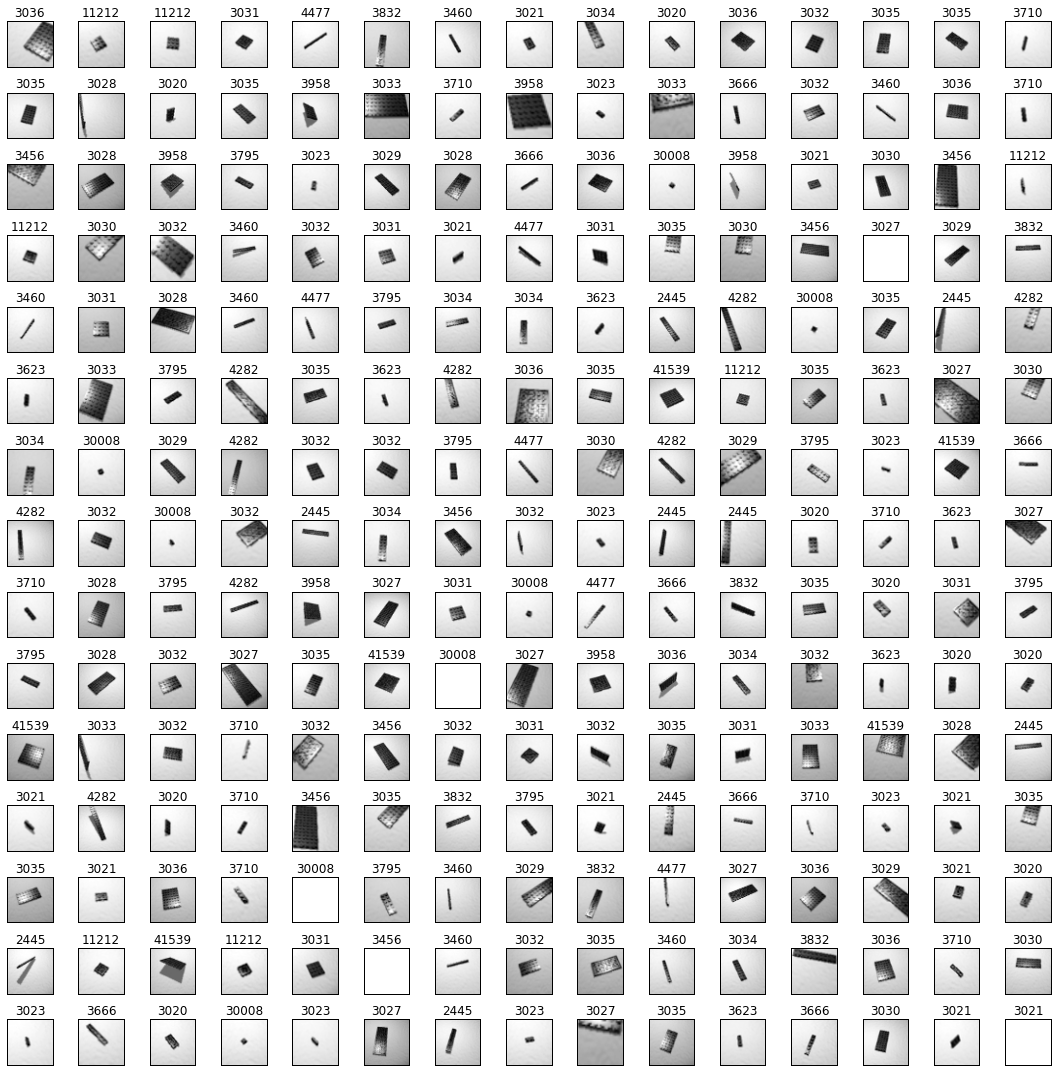

In [81]:
#Crop and resize images

def blur(image,strength):
    blur = cv2.blur(image,(strength,strength))
    blur = cv2.convertScaleAbs(blur)
    return blur

def extractpatch(im,pad):
    im = cv2.convertScaleAbs(im)
    #Binary Threshold for Image
    ret,thresh = cv2.threshold(im,150,255,cv2.THRESH_TOZERO)
    #Find contours in threshold image
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    try: hierarchy = hierarchy[0]
    except: hierarchy = []
    height, width = im.shape
    min_x, min_y = width, height
    max_x = max_y = 0
    # computes the bounding box for the contour, and draws it on the frame,
    for contour, hier in zip(contours, hierarchy):
        (x,y,w,h) = cv2.boundingRect(contour)
        if w > 5 and w < len(im)-5 and h > 5 and len(im)-5:
            side = max(w,h)
            if x-pad > 0 and y-pad > 0 and x+pad+side < len(im) and y+pad+side < len(im):
                rectx = x-pad
                rectx2 = x+pad+side
                recty = y-pad
                recty2 = y+pad+side
            else:
                rectx = x
                rectx2 = x+side
                recty = y
                recty2 = y+side
            crop = im[recty:recty2,rectx:rectx2]
            return cv2.resize(crop, (image_size, image_size))
        
image_size = 48
patches = np.zeros((num_img,image_size,image_size))
i = 0

for brick in images:
#    blurred = blur(brick, 1)
#    patches[i] = cv2.resize(brick, (image_size, image_size))
    patches[i] = extractpatch(brick,16)
    i +=1

def plotImageArray(numimPlot,imageArray,labelArray):
    fig = plt.figure(figsize=(numimPlot, numimPlot))
    for i in range(0,numimPlot*numimPlot):
        a = fig.add_subplot(numimPlot,numimPlot,i)
        randim = np.random.randint(len(imageArray))
        imgplot = plt.imshow(imageArray[randim],cmap='gray')
        plt.xticks(())
        plt.yticks(())
        a.set_title(labelArray[randim])
    plt.tight_layout()
    
#Plot a selection of images
plotImageArray(15,patches,labels_text)

In [80]:
# Transform text labels from folder names into categorical labels to be
# used for the categorical_crossentropy objective
le = preprocessing.LabelEncoder()
le.fit(labels_text)
int_labels = le.transform(labels_text)
categorical_labels = to_categorical(int_labels, nb_classes=None)

print categorical_labels.shape
# To get the text label back out, use `le.inverse_transform(3)`
print le.inverse_transform(3)

(27182, 27)
3020


24463 train samples
2719 test samples
X_train shape: (24463, 48, 48, 1)
Y_train shape: (24463, 27)
X_val shape: (2719, 48, 48, 1)
Y_val shape: (2719, 27)
Max Val of Train X 0.87451
Training
Validation


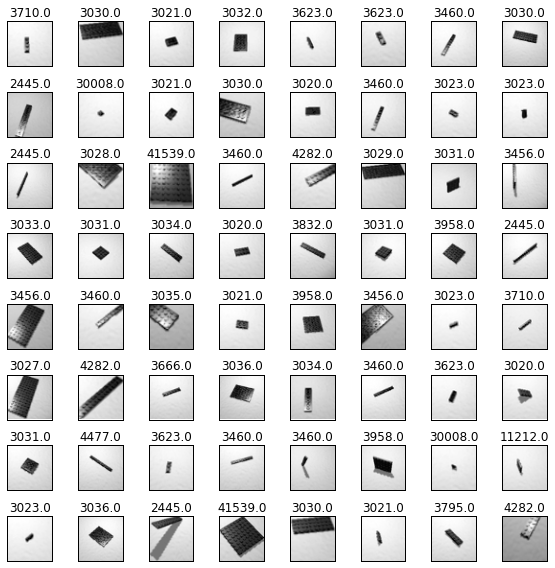

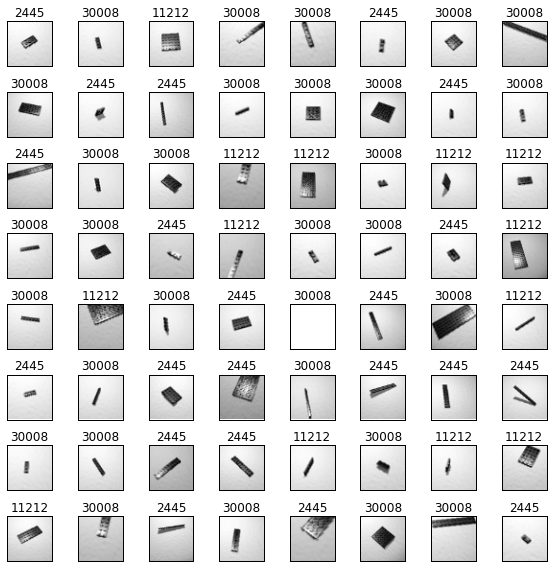

In [107]:
# Split training and validation datasets

imageArray = patches
percentage = 0.1

img_rows, img_cols = imageArray.shape[1:]
images_dim = np.expand_dims(imageArray, axis=3)

X_train, X_val, Y_train, Y_val = train_test_split(images_dim,categorical_labels, 
                                                  test_size=percentage, random_state=12)

Y_train_text = np.zeros(Y_train.shape[0])
for i in range(0,len(Y_train_text)):
    a = np.argmax(Y_train[i])
    Y_train_text[i] = le.inverse_transform(a)

X_train = X_train.astype('float32')
X_train /= 255
X_val = X_val.astype('float32')
X_val /= 255

print X_train.shape[0], 'train samples'
print X_val.shape[0], 'test samples'
print 'X_train shape:', X_train.shape
print 'Y_train shape:', Y_train.shape
print 'X_val shape:', X_val.shape
print 'Y_val shape:', Y_val.shape
print 'Max Val of Train X', np.max(X_train[0])

print 'Training'
plotImageArray(8,X_train[:,:,:,0],Y_train_text)

print 'Validation'
plotImageArray(8,X_val[:,:,:,0],labels_text)

In [ ]:
#Model Parameters and Training for VGG-style network
import tensorflow as tf

tf.python.control_flow_ops = tf
batch_size = 100
nb_classes = categorical_labels.shape[1]
nb_epoch = 20

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='valid',
                        input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])




# Optional Model Weight Loading
#model.load_weights('/Users/ckruse/Documents/Python/LegoModel/model/keras_model_128px_white_weights2.h5')

model.fit(X_train, Y_train,
            batch_size=batch_size,
            nb_epoch=nb_epoch,
            verbose=1,
            show_accuracy=True,
#            validation_split = 0.1,
            validation_data=(X_val, Y_val),
            shuffle=True)


In [49]:
#Model Parameters and Training for LM-style
import tensorflow as tf
from keras_tqdm import TQDMCallback
batch_size = 32
nb_classes = categorical_labels.shape[1]
nb_epoch = 3

model = Sequential()

model.add(Convolution2D(16, 3, 3, border_mode='valid',
                        input_shape=(image_size,image_size,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(32, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])




# Optional Model Weight Loading
#model.load_weights('/Users/ckruse/Documents/Python/LegoModel/model/keras_model_32px_LMweights.h5')

model.fit(X_train, Y_train,
            batch_size=batch_size,
            nb_epoch=nb_epoch,
            verbose=0,
            show_accuracy=True,
#            validation_split = 0.1,
            validation_data=(X_val, Y_val),
            shuffle=True,
            callbacks=[TQDMCallback()])



/usr/local/lib/python2.7/site-packages/keras/models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '
Epoch: 0:   0%|          | 0/3 [00:00<?, ?it/s]
Epoch: 0 - loss: 3.296, acc: 0.043, val_loss: 3.296, val_acc: 0.047100%|██████████| 3/3 [00:13<00:00,  4.63s/it]
Epoch: 1:   0%|          | 0/3 [00:00<?, ?it/s]
Epoch: 1 - loss: 3.296, acc: 0.044, val_loss: 3.295, val_acc: 0.047100%|██████████| 3/3 [00:12<00:00,  4.30s/it]
Epoch: 2:   0%|          | 0/3 [00:00<?, ?it/s]
Epoch: 2 - loss: 3.295, acc: 0.044, val_loss: 3.295, val_acc: 0.047100%|██████████| 3/3 [00:12<00:00,  4.32s/it]
Training: 100%|██████████| 3/3 [00:39<00:00, 13.40s/it]


In [34]:
# Save Model
from keras.models import load_model
#model.summary()
model.save(root_path + 'keras_model_32px_LMarch.h5')
model.save_weights(root_path + 'keras_model_32px_LMweights.h5')

(50,)
('True Block ID: ', array([['3034']], 
      dtype='|S5'))
('Predicted Block ID: ', '2445')
('Confidence: ', 0.29861882)


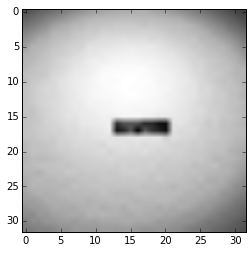

('True Block ID: ', array([['4282']], 
      dtype='|S5'))
('Predicted Block ID: ', '4282')
('Confidence: ', 0.63201559)


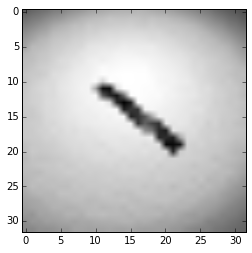

('True Block ID: ', array([['3036']], 
      dtype='|S5'))
('Predicted Block ID: ', '3958')
('Confidence: ', 0.27502599)


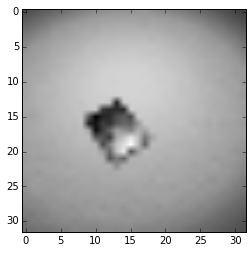

('True Block ID: ', array([['30008']], 
      dtype='|S5'))
('Predicted Block ID: ', '30008')
('Confidence: ', 0.73280656)


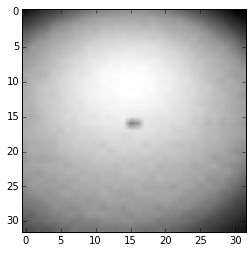

('True Block ID: ', array([['3030']], 
      dtype='|S5'))
('Predicted Block ID: ', '3030')
('Confidence: ', 0.40673557)


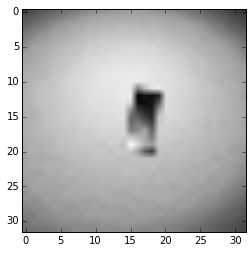

('True Block ID: ', array([['3030']], 
      dtype='|S5'))
('Predicted Block ID: ', '3035')
('Confidence: ', 0.62953085)


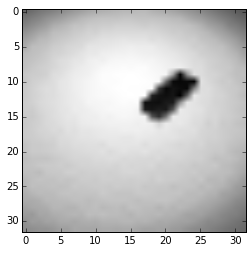

('True Block ID: ', array([['41539']], 
      dtype='|S5'))
('Predicted Block ID: ', '41539')
('Confidence: ', 0.5052458)


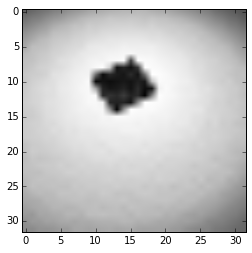

('True Block ID: ', array([['3031']], 
      dtype='|S5'))
('Predicted Block ID: ', '3031')
('Confidence: ', 0.6567511)


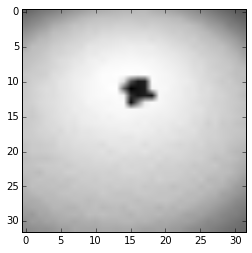

('True Block ID: ', array([['3034']], 
      dtype='|S5'))
('Predicted Block ID: ', '4282')
('Confidence: ', 0.52879423)


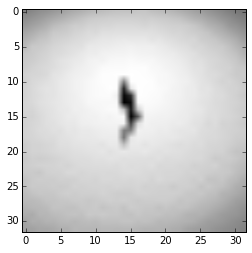

('True Block ID: ', array([['3666']], 
      dtype='|S5'))
('Predicted Block ID: ', '3666')
('Confidence: ', 0.35711205)


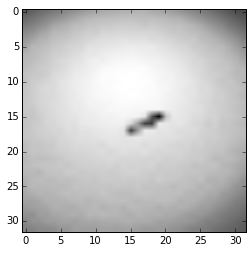

('True Block ID: ', array([['3623']], 
      dtype='|S5'))
('Predicted Block ID: ', '3710')
('Confidence: ', 0.37643224)


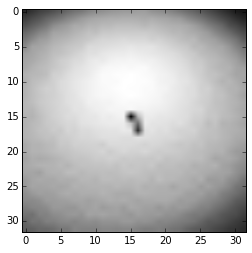

('True Block ID: ', array([['2445']], 
      dtype='|S5'))
('Predicted Block ID: ', '4282')
('Confidence: ', 0.28711864)


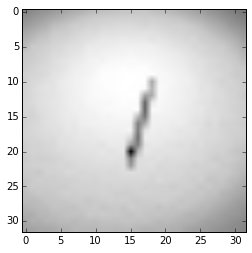

('True Block ID: ', array([['3020']], 
      dtype='|S5'))
('Predicted Block ID: ', '11212')
('Confidence: ', 0.47782132)


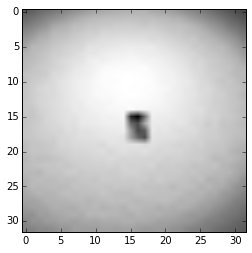

('True Block ID: ', array([['3021']], 
      dtype='|S5'))
('Predicted Block ID: ', '3021')
('Confidence: ', 0.43338433)


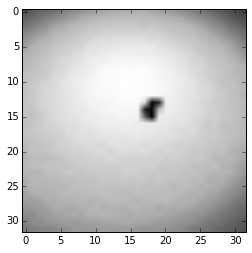

('True Block ID: ', array([['3023']], 
      dtype='|S5'))
('Predicted Block ID: ', '3623')
('Confidence: ', 0.32568148)


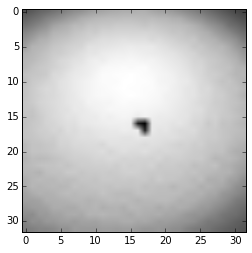

('True Block ID: ', array([['3034']], 
      dtype='|S5'))
('Predicted Block ID: ', '3832')
('Confidence: ', 0.48309776)


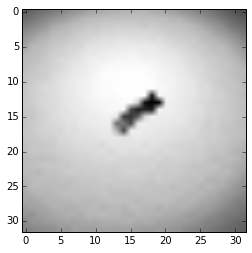

('True Block ID: ', array([['3832']], 
      dtype='|S5'))
('Predicted Block ID: ', '4282')
('Confidence: ', 0.891927)


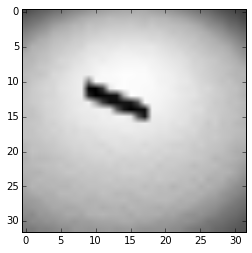

('True Block ID: ', array([['3029']], 
      dtype='|S5'))
('Predicted Block ID: ', '3029')
('Confidence: ', 0.50704288)


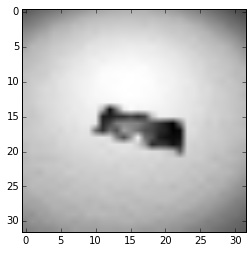

('True Block ID: ', array([['3623']], 
      dtype='|S5'))
('Predicted Block ID: ', '3023')
('Confidence: ', 0.50683928)


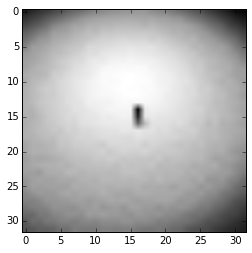

('True Block ID: ', array([['3028']], 
      dtype='|S5'))
('Predicted Block ID: ', '3028')
('Confidence: ', 0.25746018)


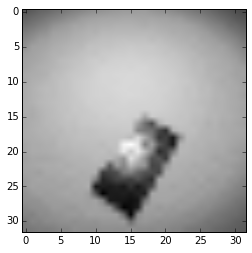

('True Block ID: ', array([['11212']], 
      dtype='|S5'))
('Predicted Block ID: ', '11212')
('Confidence: ', 0.68189019)


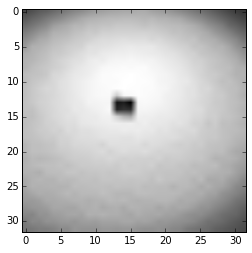

('True Block ID: ', array([['3030']], 
      dtype='|S5'))
('Predicted Block ID: ', '3029')
('Confidence: ', 0.46981511)


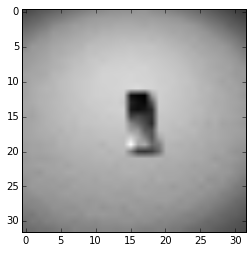

('True Block ID: ', array([['3033']], 
      dtype='|S5'))
('Predicted Block ID: ', '3033')
('Confidence: ', 0.54094172)


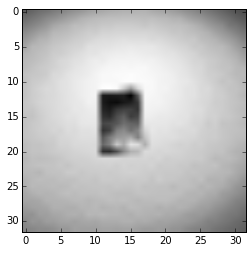

('True Block ID: ', array([['3032']], 
      dtype='|S5'))
('Predicted Block ID: ', '4477')
('Confidence: ', 0.29960161)


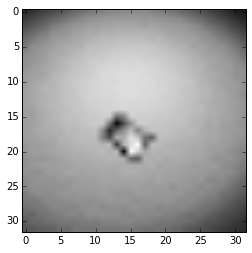

('True Block ID: ', array([['3028']], 
      dtype='|S5'))
('Predicted Block ID: ', '3028')
('Confidence: ', 0.47248036)


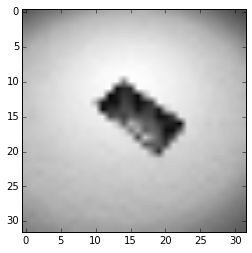

('True Block ID: ', array([['3034']], 
      dtype='|S5'))
('Predicted Block ID: ', '2445')
('Confidence: ', 0.29638252)


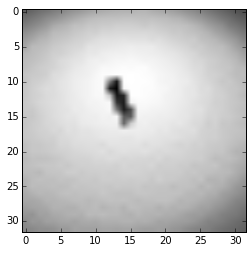

('True Block ID: ', array([['3020']], 
      dtype='|S5'))
('Predicted Block ID: ', '11212')
('Confidence: ', 0.69479018)


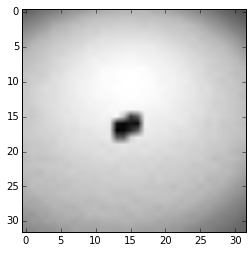

('True Block ID: ', array([['41539']], 
      dtype='|S5'))
('Predicted Block ID: ', '3033')
('Confidence: ', 0.41086444)


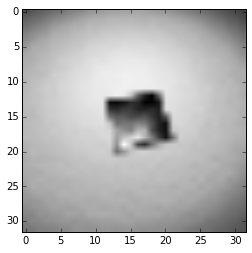

('True Block ID: ', array([['30008']], 
      dtype='|S5'))
('Predicted Block ID: ', '3023')
('Confidence: ', 0.61004823)


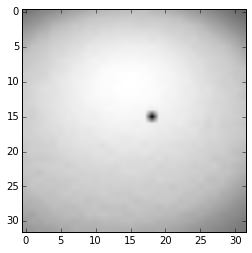

('True Block ID: ', array([['3032']], 
      dtype='|S5'))
('Predicted Block ID: ', '3030')
('Confidence: ', 0.54194689)


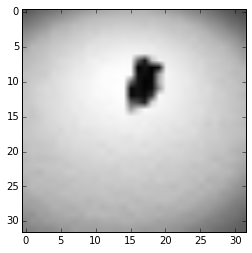

('True Block ID: ', array([['3036']], 
      dtype='|S5'))
('Predicted Block ID: ', '3033')
('Confidence: ', 0.62186772)


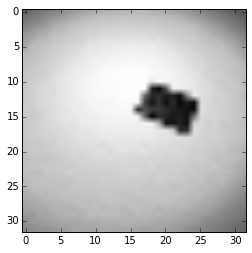

('True Block ID: ', array([['3034']], 
      dtype='|S5'))
('Predicted Block ID: ', '3034')
('Confidence: ', 0.52627856)


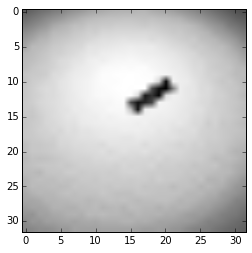

('True Block ID: ', array([['3032']], 
      dtype='|S5'))
('Predicted Block ID: ', '3032')
('Confidence: ', 0.53786939)


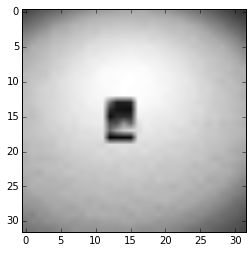

('True Block ID: ', array([['3031']], 
      dtype='|S5'))
('Predicted Block ID: ', '3460')
('Confidence: ', 0.3888886)


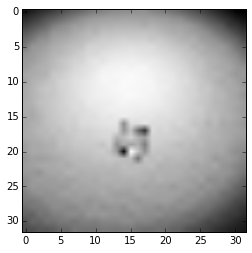

('True Block ID: ', array([['3033']], 
      dtype='|S5'))
('Predicted Block ID: ', '3033')
('Confidence: ', 0.33534983)


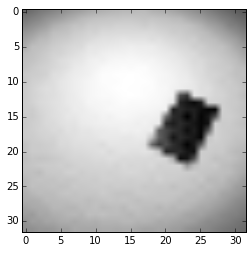

('True Block ID: ', array([['3832']], 
      dtype='|S5'))
('Predicted Block ID: ', '3034')
('Confidence: ', 0.27923468)


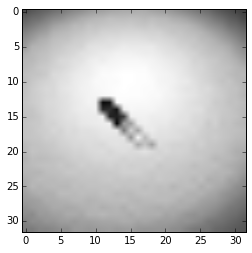

('True Block ID: ', array([['3030']], 
      dtype='|S5'))
('Predicted Block ID: ', '3030')
('Confidence: ', 0.45541012)


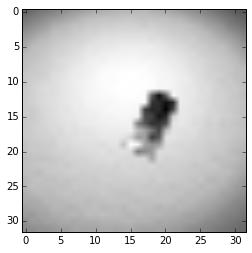

('True Block ID: ', array([['3460']], 
      dtype='|S5'))
('Predicted Block ID: ', '3460')
('Confidence: ', 0.48655239)


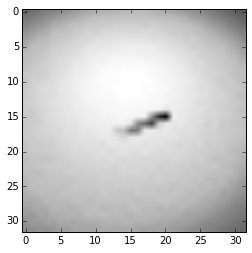

('True Block ID: ', array([['3710']], 
      dtype='|S5'))
('Predicted Block ID: ', '3710')
('Confidence: ', 0.34354034)


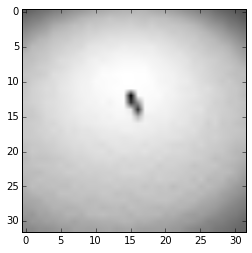

('True Block ID: ', array([['3034']], 
      dtype='|S5'))
('Predicted Block ID: ', '4477')
('Confidence: ', 0.3193073)


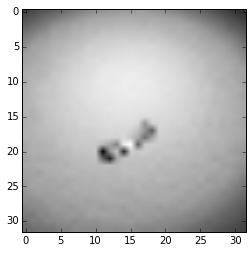

('True Block ID: ', array([['3021']], 
      dtype='|S5'))
('Predicted Block ID: ', '11212')
('Confidence: ', 0.45385256)


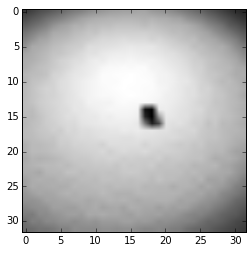

('True Block ID: ', array([['3035']], 
      dtype='|S5'))
('Predicted Block ID: ', '3035')
('Confidence: ', 0.70425093)


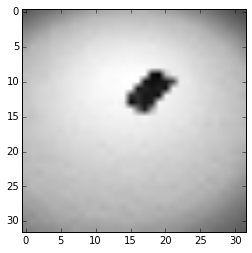

('True Block ID: ', array([['3036']], 
      dtype='|S5'))
('Predicted Block ID: ', '3033')
('Confidence: ', 0.5041396)


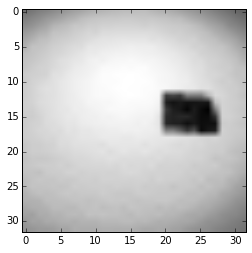

('True Block ID: ', array([['3035']], 
      dtype='|S5'))
('Predicted Block ID: ', '3030')
('Confidence: ', 0.3778688)


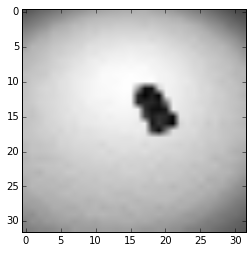

('True Block ID: ', array([['3020']], 
      dtype='|S5'))
('Predicted Block ID: ', '3795')
('Confidence: ', 0.37800804)


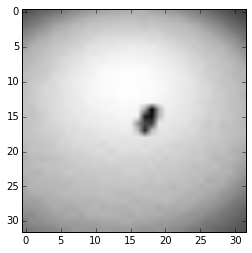

('True Block ID: ', array([['3666']], 
      dtype='|S5'))
('Predicted Block ID: ', '3460')
('Confidence: ', 0.56701601)


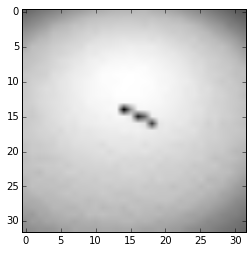

('True Block ID: ', array([['3030']], 
      dtype='|S5'))
('Predicted Block ID: ', '3035')
('Confidence: ', 0.2650288)


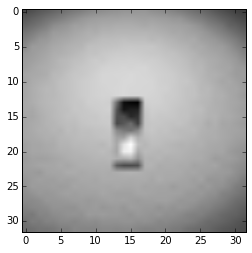

('True Block ID: ', array([['3029']], 
      dtype='|S5'))
('Predicted Block ID: ', '3036')
('Confidence: ', 0.24038358)


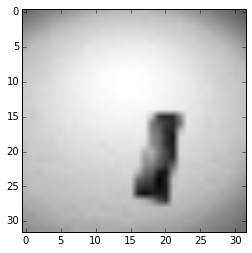

('True Block ID: ', array([['11212']], 
      dtype='|S5'))
('Predicted Block ID: ', '3795')
('Confidence: ', 0.61812615)


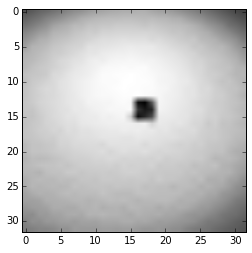

('True Block ID: ', array([['3031']], 
      dtype='|S5'))
('Predicted Block ID: ', '3795')
('Confidence: ', 0.52490097)


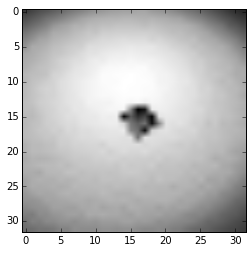

In [35]:
# Visualize a set of test predictions

num_images = 50
image_set = np.random.randint(0, X_train.shape[0], num_images)
#image_set = range(1000,1010)
print(image_set.shape)
n = 0

for image in image_set:
    itemindex = np.where(Y_train[image]==1)
    print("True Block ID: ", le.inverse_transform(itemindex))
    prediction = model.predict(X_train[image_set,:,:,:],batch_size=2,verbose=False)
    print("Predicted Block ID: ", le.inverse_transform(np.argmax(prediction[n])))
    print("Confidence: ", np.amax(prediction[n]))
    n = n+1
    plt.imshow(X_train[image,:,:,0], cmap='gray')
    plt.show()


In [36]:
# Generate some statistics on prediction success rates
success = np.zeros(Y_val.shape[1])
num = np.zeros(Y_val.shape[1])
confidence = np.zeros(Y_val.shape[1])
prediction = model.predict(X_val[range(0,Y_val.shape[0]),:,:,:],batch_size=5,verbose=True)

for image in range(0,Y_val.shape[0]):
    itemindex = np.where(Y_val[image]==1)[0]

    # Get count of items in the dataset
    num[itemindex] += 1
    
    # Check the total number of correct predictions
    truth = le.inverse_transform(itemindex[0])
    model_out = le.inverse_transform(np.argmax(prediction[image]))
    if truth == model_out:
        success[itemindex] += 1
        # Compile total sum of confidences
        confidence[itemindex] += np.amax(prediction[image])

success_rate = np.divide(success,num)
confidence_rate = np.divide(confidence,num)
for i in range(0,Y_val.shape[1]):
    print("Success Rate:", le.inverse_transform(i), 100*round(success_rate[i],3))
for i in range(0,Y_val.shape[1]):
    print("Mean Correct Confidence:", le.inverse_transform(i), 100*round(confidence_rate[i],3))
for i in range(0,Y_val.shape[1]):
    print("Number of Samples:", le.inverse_transform(i), num[i])

2705/2719 [============================>.] - ETA: 0s('Success Rate:', '11212', 52.7)
('Success Rate:', '2445', 41.699999999999996)
('Success Rate:', '30008', 82.1999999

('Prediction:', '3031')
('Confidence:', 0.88991213)


<function matplotlib.pyplot.show>

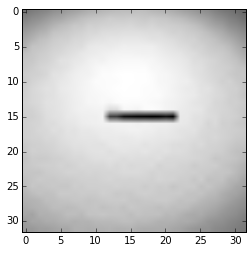

In [38]:
test_brick_images = np.zeros([img_rows,img_cols])
test_brick = misc.imread('/Users/ckruse/Downloads/brick_5mod2.jpg')
image_size = 32

blurred = blur(brick, 1)
test_brick = cv2.resize(blurred, (image_size, image_size))

test_brick = np.rollaxis(test_brick, 0,0)
test_image = np.dstack((test_brick_images, test_brick))
test_brick_images = np.dstack((test_brick_images, test_brick))
#test_brick_images = np.delete(test_brick_images,0,axis=2)
test_brick_images = np.expand_dims(test_brick_images, axis=3)
test_brick_images = np.rollaxis(test_brick_images,2,0)
print('Prediction:',le.inverse_transform(np.argmax(model.predict(test_brick_images,batch_size=1,verbose=False)[1])))
print('Confidence:', np.amax(model.predict(test_brick_images,batch_size=1,verbose=False)[1]))

plt.imshow(test_brick,cmap='gray')
plt.show


In [ ]:

# for a in range(750,760):
#     print(Y_train[a])
#     print(X_train.shape)
#     itemindex = np.where(Y_train[a]==1)
#     print(le.inverse_transform(itemindex))
#     print(images[:,:,a].shape)
#     plt.imshow(images[:,:,a])
#     plt.show()


In [ ]:
# img_num = 100
# std_x = np.zeros(len(images[:,0,img_num]))
# std_y = np.zeros(len(images[:,0,img_num]))
# for i in range(0,len(images[:,0,img_num])):
#     std_x[i] = np.std(images[i,:,img_num])
# for j in range(0,len(images[0,:,img_num])):
#     std_y[i] = np.std(images[:,j,img_num])

# max_x = np.argmax(std_x)
# max_y = np.argmax(std_y)
# print(max_x, max_y)
# test_img = images[:,:,img_num]
# test_img[max_x,:] = 255
# test_img[:,max_y] = 255
# plt.imshow(test_img[:,:])
# plt.show()
# plt.imshow(images[:,:,img_num])
# plt.show()

In [ ]:
# from skimage.feature import blob_dog, blob_log, blob_doh
# from skimage.color import rgb2gray
# from skimage import feature

# img_num = 3000
# edges = feature.canny(images[:,:,img_num],sigma=2)

# plt.imshow(edges)
# plt.show()
# plt.imshow(images[:,:,img_num])
# plt.show()

In [ ]:
# import cv2
# import math
# im = cv2.imread('/Users/ckruse/Downloads/hybrid_brick.jpg',0)
# plt.imshow(im)
# plt.show()
# print(im.shape)
# im2, contours, hierarchy = cv2.findContours(im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# print(contours)
# try: hierarchy = hierarchy[0]
# except: hierarchy = []
# height, width = im.shape
# min_x, min_y = width, height
# max_x = max_y = 0

# # computes the bounding box for the contour, and draws it on the frame,
# for contour, hier in zip(contours, hierarchy):
#     (x,y,w,h) = cv2.boundingRect(contour)
#     print(x,y,w,h)
#     min_x, max_x = min(x, min_x), max(x+w, max_x)
#     min_y, max_y = min(y, min_y), max(y+h, max_y)
#     if w > 10 and h > 10:
#         cv2.rectangle(im, (x,y), (x+w,y+h), (255, 0, 0), 2)

# if max_x - min_x > 0 and max_y - min_y > 0:
#     cv2.rectangle(im, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

# plt.imshow(im)
# plt.show()

In [ ]:
# im = cv2.imread('/Users/ckruse/Documents/Unity/Lego Sim II/screenshots/3027 (2017-03-19_10-21-057211).png',0)

# thresh_med = int(np.median(im))
# thresh_med = 110
# ret,thresh = cv2.threshold(im,thresh_med,255,0)
# for i in range(0,len(thresh)):
#     for j in range(0,len(thresh)):
#         if min(thresh[i][:]) == 0:
#             if min(thresh[:][j]) == 0:
#                 bounds_y = [i,j]
#                 break
# for i in range(0,len(thresh)):
#     for j in range(0,len(thresh)):
#         if min(thresh[:][j]) == 0:
#             if min(thresh[i][:]) == 0:
#                 bounds_x = [i,j]
#                 break
# print(bounds_x,bounds_y)
# im3,contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# plt.imshow(im3)
# plt.show()
# plt.imshow(im,cmap='Greys_r')
# #plt.imshow(im3,cmap='Greys_r')
# x = []
# y = []
# w = []
# h = []
# for i in range(0, len(contours)):
#     if (i % 2 == 0):
#        cnt = contours[i]

#        #mask = np.zeros(im2.shape,np.uint8)
#        #cv2.drawContours(mask,[cnt],0,255,-1)
#        x.append(cv2.boundingRect(cnt)[0])
#        y.append(cv2.boundingRect(cnt)[1])
#        w.append(cv2.boundingRect(cnt)[2])
#        h.append(cv2.boundingRect(cnt)[3])

# index_max = np.argmax(w)
# cv2.rectangle(im,(min_xy[0],min_xy[1]),(min_xy[0]+1,min_xy[0]+1),(0,0,0),2)
# #cv2.rectangle(im,(x[index_max],y[index_max]),(x[index_max]+w[index_max],y[index_max]+h[index_max]),(0,0,0),2)
# plt.imshow(im,cmap='Greys_r')

In [ ]:
import cv2

# Import Data

# input image dimensions
img_rows, img_cols = 128, 128
img_channels = 1

#Create main image array
images = np.zeros([img_rows,img_cols])
labels_text = []

#List folders in the root directory
root_path = '/Users/ckruse/Documents/Python/LegoModel/Bricks/'
root_folders = listdir(root_path)

#Load images into image_array by iterating through all the folders in the root directory
for folder in root_folders:
    if isfile(folder) == False:
        print(folder)
        folder_files = listdir("%s%s" % (root_path, folder))
        for brick in folder_files:
            img = cv2.imread("%s%s/%s" % (root_path, folder, brick))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            imagesa = np.dstack((imagesa, img))
            labels_text.append(folder)

imagesa = np.delete(images,0,axis=2)
print(imagesa.shape)
print('done')

In [ ]:
print(dict([(layer.name, layer) for layer in model.layers]))


In [77]:
x = np.arange(20).reshape((10, 2))
y = range(0,10)

print x
print y

X_train, X_val, Y_train, Y_val = train_test_split(x,y, 
                                                  test_size=0.15, random_state=12)

print 'xtrain', X_train 
print 'ytrain', Y_train
print 'xval', X_val
print 'yval', Y_val

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
xtrain [[14 15]
 [ 0  1]
 [ 8  9]
 [18 19]
 [ 6  7]
 [ 4  5]
 [ 2  3]
 [12 13]]
ytrain [7, 0, 4, 9, 3, 2, 1, 6]
xval [[10 11]
 [16 17]]
yval [5, 8]
